<div align="right"><b>Бронников Егор ПМ-1901</b></div>

# <center>Адаптивные методы прогнозирования</center>

## Модули

In [1]:
import pandas as pd
import numpy as np
from typing import List, Union
import warnings
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

## Данные

In [2]:
ausair = pd.read_csv('data/ausair.csv', index_col=0)

In [3]:
ausair.head()

,Passengers
Year,
1970,7.32
1971,7.33
1972,7.80
1973,9.38
1974,10.66


<AxesSubplot:xlabel='Year'>

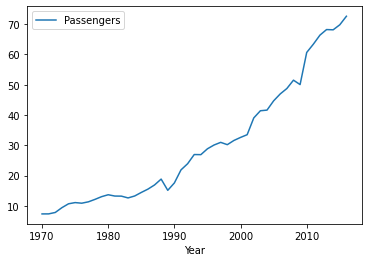

In [4]:
ausair.plot()

In [5]:
vals = ausair['Passengers'].values

## Метод Брауна

In [6]:
forecast = [vals[0]]

h = 10

alpha = 0.8

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    forecast.append(alpha * value + (1 - alpha) * forecast[t-1])

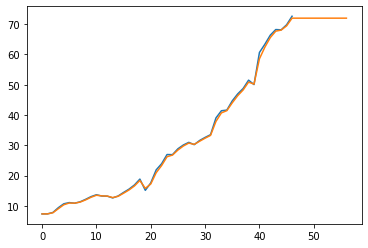

In [7]:
plt.plot(vals)
plt.plot(forecast)

## Метод Хольта

### Линейный тренд

In [8]:
forecast = [vals[0]]
level = vals[0]
trend = vals[1] - vals[0]
h = 10

alpha = 0.59
beta = 0.43

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level = level
    level = alpha * value + (1 - alpha) * (level + trend)
    trend = beta * (level - prev_level) + (1 - beta) * trend
    forecast.append(level + trend)

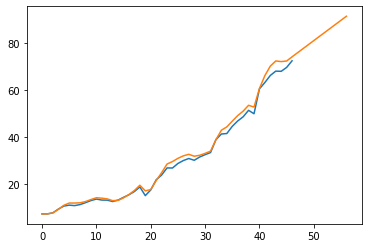

In [9]:
plt.plot(vals)
plt.plot(forecast)

### Аддитивный затухающий тренд

In [10]:
forecast = [vals[0]]
level = vals[0]
trend = vals[1] - vals[0]

h = 10

alpha = 0.39
beta = 0.10
phi = 0.9

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level = level
    level = alpha * value + (1 - alpha) * (level + phi * trend)
    trend = beta * (level - prev_level) + (1 - beta) * phi * trend
    forecast.append(level + trend)

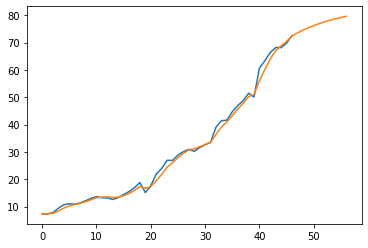

In [11]:
plt.plot(vals)
plt.plot(forecast)

## Метод Хольта-Уинтерса

### Данные

In [12]:
passengers = pd.read_csv('data/passengers.csv', index_col=0)

In [13]:
vals = passengers['num_passengers'].values

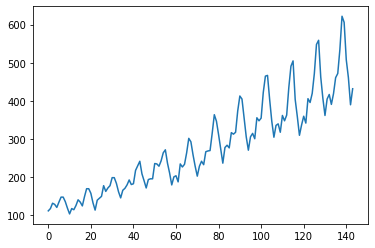

In [14]:
plt.plot(vals)

### Метод

In [15]:
forecast = [vals[11]]
level = vals[11]
trend = np.mean(vals[12:24] - np.mean(vals[:12]))
seasonality = (vals[:12] - np.mean(vals[:12])).tolist()

h = 36
m = 12

alpha = 0.4
beta = 0.03
gamma = 0.75

for t in range(12, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level, level = level, alpha * (value - seasonality[t-m]) + (1 - alpha) * (level + trend)
    prev_trend, trend = trend, beta * (level - prev_level) + (1 - beta) * trend
    seasonality.append(gamma * (value - prev_level - prev_trend) + (1 - gamma) * seasonality[t-m])
    forecast.append(level + trend + seasonality[t-m+1])

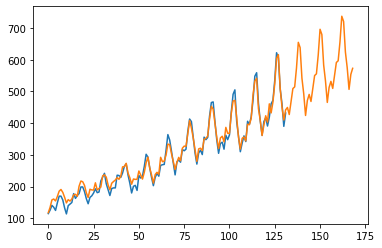

In [16]:
plt.plot(vals[12:])
plt.plot(forecast)

### Функия

In [17]:
def holt_winters(series: List[Union[int, float]],
                 h=0, m=12, alpha=0.4, beta=0.03, gamma=0.75, phi=1, *,
                 mode='additive') -> Union[List[Union[int, float]], None]:
    
    forecast = [series[11]]
    level = series[11]
    trend = np.mean(series[12:24] - np.mean(series[:12]))
    seasonality = (series[:12] - np.mean(series[:12])).tolist()
    
    if mode == 'additive':
        for t in range(12, vals.shape[0] + h):
            value = series[t] if t < series.shape[0] else forecast[-1]
            prev_level, level = level, alpha * (value - seasonality[t-m]) + (1 - alpha) * (level + phi * trend)
            prev_trend, trend = trend, beta * (level - prev_level) + (1 - beta) * phi * trend
            seasonality.append(gamma * (value - prev_level - prev_trend) + (1 - gamma) * seasonality[t-m])
            forecast.append(level + trend + seasonality[t-m+1])
        return forecast
    elif mode == 'multiplicative':
        for t in range(12, vals.shape[0] + h):
            value = series[t] if t < series.shape[0] else forecast[-1]
            prev_level, level = level, alpha * (value/seasonality[t-m]) + (1 - alpha) * (level + phi * trend)
            prev_trend, trend = trend, beta * (level - prev_level) + (1 - beta) * phi * trend
            seasonality.append(gamma * (value/(prev_level + prev_trend)) + (1 - gamma) * seasonality[t-m])
            forecast.append((level + trend) * seasonality[t-m+1])
        return forecast
    else:
        warnings.warn('Error: Wrong `mode` parameter is selected...', category=UserWarning)
        return None

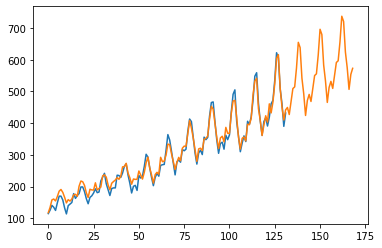

In [18]:
plt.plot(vals[12:])
plt.plot(holt_winters(vals, 36))

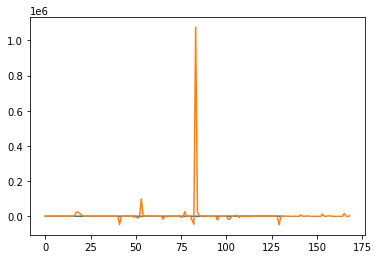

In [19]:
plt.plot(vals[12:])
plt.plot(holt_winters(vals, h=36, mode='multiplicative'))

In [20]:
holt_winters(vals, h=36, mode='errr')

/tmp/ipykernel_733759/2458228414.py:27: UserWarning: Error: Wrong `mode` parameter is selected...
  warnings.warn('Error: Wrong `mode` parameter is selected...', category=UserWarning)


### Подбор параметров

In [21]:
def mean_squared_error(series, m=12, alpha=0.4, beta=0.03, gamma=0.75, phi=1, mode='additive'):
    forecast = holt_winters(series, 0, m, alpha, beta, gamma, phi, mode=mode)
    return (np.sum((series[m:]-forecast[:-1])**2))/len(series[m:])

In [22]:
mean_squared_error(vals)

254.34230320585817

In [23]:
m = 12
phi = 1
func = lambda x: mean_squared_error(vals, m, x[0], x[1], x[2], phi, mode='additive')
bnds = ((0,None) for _ in range(3))
minimize(func, (0,0,0), bounds=bnds)

      fun: 209.9667672687944
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.30739863e-04, -7.95807864e-04,  9.66338116e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 132
      nit: 25
     njev: 33
   status: 0
  success: True
        x: array([0.42792075, 0.08373109, 0.84921901])

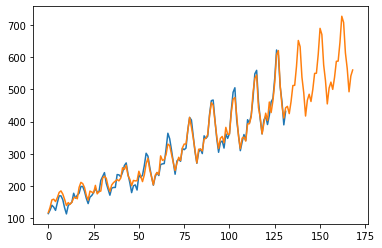

In [24]:
plt.plot(vals[12:])
plt.plot(holt_winters(vals, h=36, alpha=0.42792075, beta=0.08373109, gamma=0.84921901, phi=1))